<a href="https://colab.research.google.com/github/SailorBleu/fraud-detection-notebook/blob/main/demo_optim_data_preproc_germ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3B: Comparing Optimized Pre-Processing for Discrimination Prevention Across Different Models

## <center> **Logistic Regression**
---

In [35]:
%matplotlib inline
!pip install 'aif360[all]'
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

In [36]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [37]:
import os
import urllib
import aif360

# Obtain the location where it is installed
LIB_PATH = aif360.__file__.rsplit("aif360", 1)[0]

# check if the data got download properly
def check_data_or_download(destn, files, data_source_directory):
    check = all(item in os.listdir(destn) for item in files)
    if check:
        print("Adult dataset is available for us")
    else:
        print("Some files are missing. Downloading now.")
        for data_file in files:
            _ = urllib.request.urlretrieve(data_source_directory + data_file,
                                           os.path.join(destn, data_file))

# Download german dataset
data_source_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/"
destn = os.path.join(LIB_PATH, "aif360", "data", "raw", "german")
files = ["german.data"]
dataset_used =  "german"
protected_attribute_used = 1 # 1, 2

check_data_or_download(destn, files, data_source_directory)

Some files are missing. Downloading now.


#### Load dataset and specify options

In [38]:
# import dataset

dataset_used == "german"
if protected_attribute_used == 1:
  privileged_groups = [{'sex': 1}]
  unprivileged_groups = [{'sex': 0}]
  dataset_orig = load_preproc_data_german(['sex'])
  optim_options = {
      "distortion_fun": get_distortion_german,
      "epsilon": 0.05,
      "clist": [0.99, 1.99, 2.99],
      "dlist": [.1, 0.05, 0]
      }
else:
  privileged_groups = [{'age': 1}]
  unprivileged_groups = [{'age': 0}]
  dataset_orig = load_preproc_data_german(['age'])
  optim_options = {
      "distortion_fun": get_distortion_german,
      "epsilon": 0.1,
      "clist": [0.99, 1.99, 2.99],
      "dlist": [.1, 0.05, 0]
      }

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['personal_status'].replace(status_map)


#### Display dataset attributes

In [39]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


#### Metric for original training data

In [40]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.066728


#### Train with and transform the original training data

In [41]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:329: FutureWarn

Optimized Preprocessing: Objective converged to 0.000000


/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opti

#### Metric with the transformed training data

In [42]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.028620


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [43]:
### Testing
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

#### Load, clean up original test data and compute metric

In [44]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(150, 11)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.068980


#### Transform test data and compute metric

In [45]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opti

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.018395


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [46]:
### Testing
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [47]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores original test set

In [48]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [49]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.6975
Optimal classification threshold (no fairness constraints) = 0.7029


### Predictions and fairness metrics from original test set

In [51]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
  fav_inds = dataset_orig_test_pred.scores > thresh
  dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
  dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

  if (thresh == best_class_thresh):
    disp = True
  else:
    disp = False

    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred,
                                      unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

print("Original Dataset Balanced Accuracy:", bal_acc_arr_orig)
print("Original Dataset Disparate Impact:", disp_imp_arr_orig)

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

100%|██████████| 100/100 [00:00<00:00, 269.05it/s]

Original Dataset Balanced Accuracy: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.49523809523809526, 0.49523809523809526, 0.5253968253968254, 0.5253968253968254, 0.5428571428571428, 0.5714285714285714, 0.5666666666666667, 0.5666666666666667, 0.573015873015873, 0.573015873015873, 0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 0.6015873015873016, 0.6253968253968254, 0.6253968253968254, 0.6253968253968254, 0.626984126984127, 0.638095238095238, 0.6333333333333333, 0.6333333333333333, 0.6523809523809523, 0.6523809523809523, 0.6523809523809523, 0.6587301587301587, 0.6555555555555556, 0.6507936507936508, 0.6126984126984127, 0.5968253968253968, 0.5968253968253968, 0.6174603174603175, 0.6126984126984127, 0.6126984126984127, 0.6063492063492064, 0.6063492063492064, 0.5650793650793651, 0.56507936

Found existing installation: matplotlib 3.9.2
Uninstalling matplotlib-3.9.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.9.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/matplotlib/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.10/dist-packages/pylab.py
Proceed (Y/n)? y
  Successfully uninstalled matplotlib-3.9.2
  Using cached matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.20.0 requires matplotlib>=3.5, but you have matplotlib 3.1.3 which is incompatible.
bigframes 1.27.0 requires matplotlib>=3.7.1, but you have matplotlib 3.1.3 which is incompatible.
ipympl 0.9.4 requires matplotl

Disparate Impact at the best Balanced Accuracy threshold: 0.00521739130434784


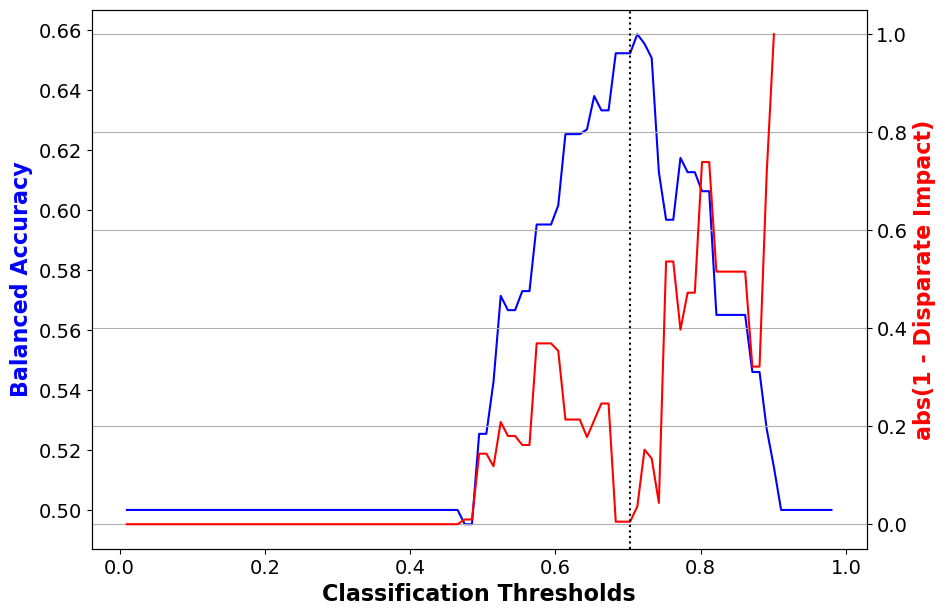

In [56]:
%pip uninstall matplotlib
%pip install matplotlib==3.1.3

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot balanced accuracy on the left y-axis
ax1.plot(class_thresh_arr, bal_acc_arr_orig, label='Balanced Accuracy', color='b')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# Create the right y-axis for Disparate Impact
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_orig)), color='r', label='abs(1 - Disparate Impact)')
ax2.set_ylabel('abs(1 - Disparate Impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# Calculate the Disparate Impact at the best threshold for Balanced Accuracy
disp_imp_at_best_bal_acc_orig = np.abs(1.0 - np.array(disp_imp_arr_orig))[best_ind]
print(f"Disparate Impact at the best Balanced Accuracy threshold: {disp_imp_at_best_bal_acc_orig}")

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair.

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [57]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [58]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [63]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
  fav_inds = dataset_transf_test_pred.scores > thresh
  dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
  dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

  # Calculate and append metrics for all thresholds
  metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred,
                                    unprivileged_groups, privileged_groups, disp=False)

  bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
  avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
  disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

  # Display detailed metrics for the best threshold if desired
  if thresh == best_class_thresh:
    compute_metrics(dataset_transf_test, dataset_transf_test_pred,
                    unprivileged_groups, privileged_groups, disp=True)

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

100%|██████████| 99/99 [00:00<00:00, 768.46it/s]

Balanced accuracy = 0.6587
Statistical parity difference = 0.0071
Disparate impact = 1.0151
Average odds difference = 0.0139
Equal opportunity difference = 0.0112
Theil index = 0.3809


```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


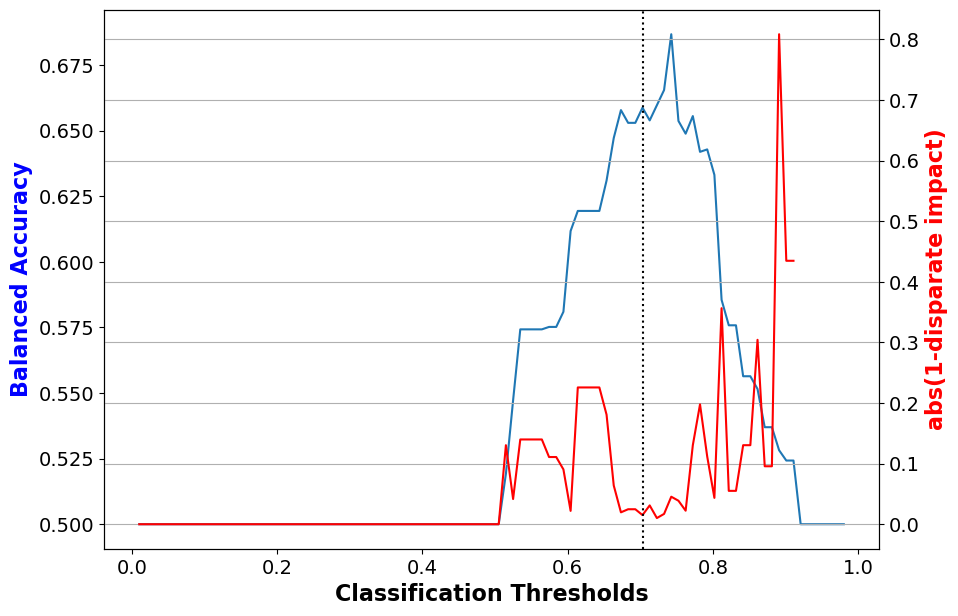

In [64]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [68]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

AssertionError: 

In [69]:
print(f"Disparate Impact before transformation: {(disp_imp_at_best_bal_acc_orig)}")
print(f"Disparate Impact after transformation: {(disp_imp_at_best_bal_acc_transf)}")

Disparate Impact before transformation: 0.00521739130434784
Disparate Impact after transformation: 0.015084294587400127


# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

In [70]:
# Retrieve optimal classification thresholds
best_class_thresh_german = best_class_thresh

# For Balanced Accuracy (before fairness constraints)
bal_acc_german_bef = bal_acc_arr_orig[best_ind]

# For Disparate Impact (before fairness constraints)
disp_imp_german_bef = disp_imp_at_best_bal_acc_orig

# For Balanced Accuracy (after fairness constraints)
bal_acc_german_aft = bal_acc_arr_transf[best_ind]

# For Disparate Impact (after fairness constraints)
disp_imp_german_aft = disp_imp_at_best_bal_acc_transf

In [71]:
import numpy as np
import pandas as pd

num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]


# Retrieve the optimal classification thresholds for each dataset
thresholds_data = {
    "Dataset": ["German"],
    "Classification Threshold": [
        best_class_thresh_german,  # Calculated during the loop for the German dataset
    ]
}

# Create a DataFrame to store the classification thresholds
thresholds_df = pd.DataFrame(thresholds_data)

In [72]:
result_table = pd.DataFrame({
    'Dataset': ['German'],
    'Sex (Acc-Bef)': [bal_acc_german_bef],
    'Sex (Acc-Aft)': [bal_acc_german_aft],
    'Sex (Fair-Bef)': [disp_imp_german_bef],
    'Sex (Fair-Aft)': [disp_imp_german_aft],
    'Race/Age (Acc-Bef)': [bal_acc_german_bef],
    'Race/Age (Acc-Aft)': [bal_acc_german_aft],
    'Race/Age (Fair-Bef)': [disp_imp_german_bef],
    'Race/Age (Fair-Aft)': [disp_imp_german_aft]
    })

# Example using k-means from scikit-learn:
from sklearn.cluster import KMeans

# Assuming you want to cluster based on the numerical columns in your DataFrame:
data_to_cluster = result_table[['Sex (Acc-Bef)', 'Sex (Acc-Aft)', 'Sex (Fair-Bef)', 'Sex (Fair-Aft)',
                                'Race/Age (Acc-Bef)', 'Race/Age (Acc-Aft)', 'Race/Age (Fair-Bef)', 'Race/Age (Fair-Aft)']]

kmeans = KMeans(n_clusters=1, random_state=0)  # Set n_clusters to 1

kmeans.fit(data_to_cluster)  # Fit the model to your data
result_table['cluster'] = kmeans.labels_ # Add cluster labels to your DataFrame

print(thresholds_df)

print(result_table) # This uses the standard print function to display your dataframe

  Dataset  Classification Threshold
0  German                  0.702929
  Dataset  Sex (Acc-Bef)  Sex (Acc-Aft)  Sex (Fair-Bef)  Sex (Fair-Aft)  \
0  German       0.652381       0.658748        0.005217        0.015084   

   Race/Age (Acc-Bef)  Race/Age (Acc-Aft)  Race/Age (Fair-Bef)  \
0            0.652381            0.658748             0.005217   

   Race/Age (Fair-Aft)  cluster  
0             0.015084        0  


### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|German|0.70292|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|German|0.6524|0.6587|0.0052|0.0151|0.6524|0.6587|0.0052|0.0151|
